In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import networkx as nx
import copy



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.7.0+cu101


In [2]:
drive.mount('/content/drive')
folder_dir = '/content/drive/My Drive/cora'

Mounted at /content/drive


In [8]:
class Cora(object):
    
    def __init__(self, base_dir):
        data = np.genfromtxt(base_dir + '/cora/cora.content', dtype=np.str)
        

        self.category_list = list(set(data[:, -1]))
        self.cat2lab = {category:label for label, category in enumerate(self.category_list)}
        self.lab2cat = {label:category for label, category in enumerate(self.category_list)}
        
        self.paper_list = np.array(data[:, 0], dtype=np.int)
        self.paper2node = {paper_id:node_id for node_id, paper_id in enumerate(self.paper_list)}
        self.node2paper = {node_id:paper_id for node_id, paper_id in enumerate(self.paper_list)}


        self.node_feature = np.array(data[:, 1:-1], dtype=int)
        self.node_label = [self.cat2lab[category] for category in data[:, -1]]
        
        self.edge = np.genfromtxt(base_dir + '/cora/cora.cites',   dtype=np.int)
        self.node_connection = [[] for _ in range(data.shape[0])]


        for i, (cited, citing) in enumerate(self.edge):
            cited_node = self.paper2node[cited]
            citing_node = self.paper2node[citing]
            self.node_connection[cited_node].append(citing_node)
            self.node_connection[citing_node].append(cited_node) # undirected
            
        for i in range(data.shape[0]):
            self.node_connection[i] = np.array(list(set(self.node_connection[i])), dtype=np.int)




    def get_dataset(self):

        node_x = np.array(self.node_feature, dtype=np.int32)
        node_y = np.array(self.node_label, dtype=np.int32)
        node_neighbor_list = copy.deepcopy(self.node_connection)
        return node_x, node_y, node_neighbor_list
        

cora = Cora(base_dir='/content/drive/My Drive')




node_x, node_y, node_neighbor_list = cora.get_dataset()



In [10]:
for i in range(10):
    print( np.random.choice(node_neighbor_list[i], 1)) 

[435]
[344]
[471]
[197]
[170]
[490]
[490]
[258]
[258]
[453]


In [29]:
class Embeder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, dropout_p=0.5):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.tologits = nn.Linear(embedding_dim, num_embeddings, bias=False)


    def forward(self, index):
        emb = self.embedding(index)
        # emb = self.dropout(emb)
        return self.tologits(emb)


In [7]:
x = np.arange(0, 10)
np.random.shuffle(x)
print(x)

[4 7 5 9 0 1 6 8 2 3]


In [36]:
# def deep_walk(G, embedding_size, window_size, walk_length, num_epochs):

def deep_walk(node_neighbor_list, num_nodes, embedding_dims,  walk_length, window_size, num_epochs, learning_rate):


    model = Embeder(num_nodes, embedding_dims)
    solver = optim.Adam(model.parameters(), learning_rate)

    
    start_list = np.arange(0, num_nodes)


    for epoch in range(num_epochs):

        np.random.shuffle(start_list)

        epoch_loss = 0.0
        for i in range(num_nodes):


            # generate a walk(=sentence)
            walk = [start_list[i]]
            for t in range(walk_length):
                curr_node_neigbhors = node_neighbor_list[walk[-1]]
                selected_next_node = np.random.choice(curr_node_neigbhors, 1)[0]
                walk.append(selected_next_node)


            # walk -> data pair
            data_x = []
            data_y = []

            for j in range(walk_length):
                for k in range(j - window_size, j + window_size + 1):
                    if k >= 0 and k < walk_length:
                        data_x.append(walk[j])
                        data_y.append(walk[k])


            data_x = torch.LongTensor(data_x)
            data_y = torch.LongTensor(data_y)
            

            # one mini-batch leanring. mini-batch is data from a walk
            solver.zero_grad()
            logits = model(data_x)
        
            loss = F.cross_entropy(logits, data_y)
            loss.backward()
            epoch_loss += loss.item()
            solver.step()
                        

        if epoch % 10 == 9:

            print(epoch_loss / num_nodes)
    return model



model = deep_walk(node_neighbor_list, len(node_x), 2, 20, 3, 100, 0.01)

6.374192937174083
6.305984815959564
6.2858507930792245
6.278794331071648
6.272099440876103
6.257780825898073
6.2511167652145625
6.264473271862971
6.24617750711596
6.257389653380548


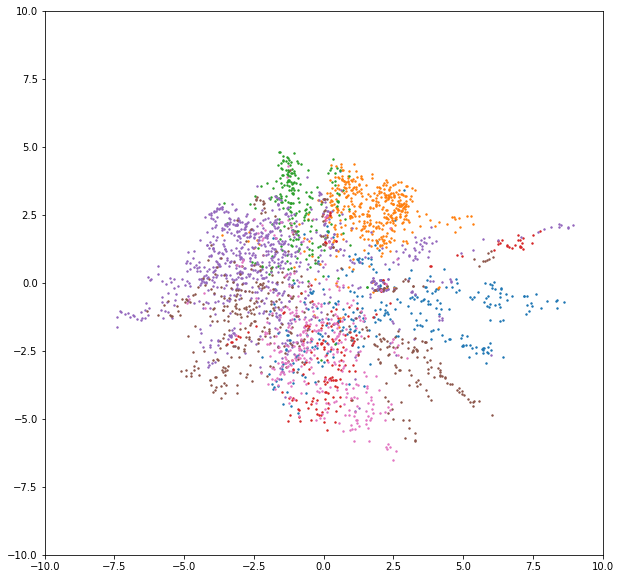

In [39]:
labels = np.array(cora.node_label)
# print(labels)

embs = model.embedding.weight.detach().numpy()
plt.figure(figsize=(10, 10))

for i in range(7):
    node_list = labels == i
    plt.scatter(embs[node_list, 0], embs[node_list, 1], s=2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.show()
